# Building single-cell and network models in Jaxley

In this first section of the tutorial, you will learn the basics of Jaxley and how to build single-cell and network models. We will cover:
- Modules (e.g., `Cell`, `Network`)
    - nodes
    - edges
- Views
    - Groups
- Channels
- Synapses
- How to connect neurons to form a network  
- Visualizing networks  
- Inspecting and changing synaptic parameters


Some typical imports for using jaxley including jaxley itself are as follows. We will use these functions for the first section of our tutorial.

In [1]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import jaxley as jx
from jaxley.channels import Na, K, Leak
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import connect, fully_connect
import matplotlib.pyplot as plt
import numpy as np

## Reading a cell from an SWC file

In [2]:
cell = jx.read_swc("mini_cell.swc", ncomp=1)

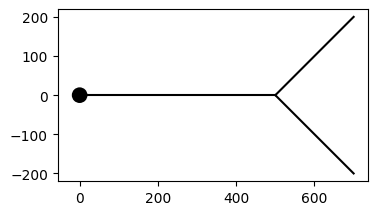

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
cell.vis(ax=ax)
ax.set_aspect("equal")

Several `Cell`s can be grouped together to form a `Network`, which can than be connected together using `Synpase`s.

In [4]:
ncells = 2
net = jx.Network([cell]*ncells)

net.shape # shows you the num_cells, num_branches, num_comps

(2, 8, 8)

Every module tracks information about its current state and parameters in two Dataframes called `nodes` and `edges`.
`nodes` contains all the information that we associate with compartments in the model (each row corresponds to one compartment) and `edges` tracks all the information relevant to synapses.

This means that you can easily keep track of the current state of your `Module` and how it changes at all times.

In [5]:
net.nodes

,local_cell_index,local_branch_index,local_comp_index,length,radius,axial_resistivity,capacitance,v,x,y,z,basal,soma,global_cell_index,global_branch_index,global_comp_index,controlled_by_param
0,0,0,0,40.000000,20.0,5000.0,1.0,-70.0,0.0,0.0,0.0,False,True,0,0,0,0
1,0,1,0,480.000000,0.2,5000.0,1.0,-70.0,260.0,0.0,0.0,True,False,0,1,1,0
2,0,2,0,282.842712,0.2,5000.0,1.0,-70.0,600.0,100.0,0.0,True,False,0,2,2,0
3,0,3,0,282.842712,0.2,5000.0,1.0,-70.0,600.0,-100.0,0.0,True,False,0,3,3,0
6,1,0,0,40.000000,20.0,5000.0,1.0,-70.0,0.0,0.0,0.0,False,True,1,4,4,0
7,1,1,0,480.000000,0.2,5000.0,1.0,-70.0,260.0,0.0,0.0,True,False,1,5,5,0
8,1,2,0,282.842712,0.2,5000.0,1.0,-70.0,600.0,100.0,0.0,True,False,1,6,6,0
9,1,3,0,282.842712,0.2,5000.0,1.0,-70.0,600.0,-100.0,0.0,True,False,1,7,7,0


In [6]:
net.edges.head() # this is currently empty since we have not made any connections yet

,global_edge_index,index_within_type,pre_index,post_index,pre_locs,post_locs,type,type_ind


## Views

Since Modules (such as this `Network` or `Cell`) can become very complex, Jaxley utilizes so called `View`s to make working with them easy and intuitive. 

The simplest way to navigate Modules is by navigating them via the hierachy that we introduced above. A `View` is what you get when you index into the module. For example, for a `Network`:

In [7]:
net.cell(0)

View with 0 different channels. Use `.nodes` for details.

Views behave very similarly to `Module`s, i.e. `net.cell(0)` (the 0th cell of the network) behaves like the `cell` we instantiated earlier. As such, `net.cell(0)` also has a `nodes` attribute, which keeps track of its part of the network:

In [8]:
net.cell(0).nodes

,local_cell_index,local_branch_index,local_comp_index,length,radius,axial_resistivity,capacitance,v,x,y,z,basal,soma,global_cell_index,global_branch_index,global_comp_index,controlled_by_param
0,0,0,0,40.000000,20.0,5000.0,1.0,-70.0,0.0,0.0,0.0,False,True,0,0,0,0
1,0,1,0,480.000000,0.2,5000.0,1.0,-70.0,260.0,0.0,0.0,True,False,0,1,1,0
2,0,2,0,282.842712,0.2,5000.0,1.0,-70.0,600.0,100.0,0.0,True,False,0,2,2,0
3,0,3,0,282.842712,0.2,5000.0,1.0,-70.0,600.0,-100.0,0.0,True,False,0,3,3,0


Let's use `View`s to visualize only parts of the `Network`.

In [9]:
# Move cells (since they are placed on top of each other by default).
net.cell(0).move_to(y=500)

We can now visualize the entire `net` (i.e., the entire `Module`) with the `.vis()` method...

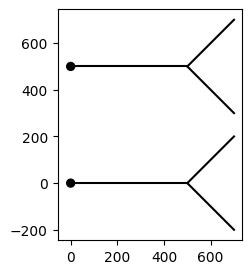

In [10]:
# We can use the vis function to visualize Modules.
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
net.vis(ax=ax)
ax.set_aspect("equal")

...but we can also create a `View` to visualize only parts of the `Net`:

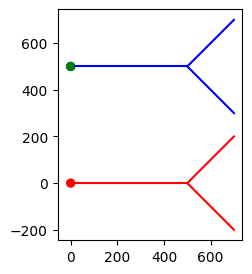

In [11]:
# ... and Views
fig, ax = plt.subplots(1,1, figsize=(3,3))
net.cell(0).vis(ax=ax, color="blue")  # View of the 0th cell of the network
net.cell(1).vis(ax=ax, color="red")  # View of the 1st cell of the network

net.cell(0).branch(0).vis(ax=ax, color="green")  # View of the 1st branch of the 0th cell of the network
ax.set_aspect("equal")

More information on creating views can be found in our [jaxley tutorial](https://github.com/jaxleyverse/jaxley/blob/main/docs/tutorials/00_jaxley_api.ipynb).

## Channels

The `Module`s that we have created above will not do anything interesting, since by default `Jaxley` initializes them without any mechanisms in the membrane. To change this, we have to insert channels into the membrane. For this purpose `Jaxley` implements `Channel`s that can be inserted into any compartment using the `insert` method of a `Module` or a `View`:

In [12]:
# insert a Leak channel into all compartments in the Module.
net.insert(Leak())
net.nodes.head() # Channel parameters are now also added to `nodes`.

,local_cell_index,local_branch_index,local_comp_index,length,radius,axial_resistivity,capacitance,v,x,y,z,basal,soma,global_cell_index,global_branch_index,global_comp_index,controlled_by_param,Leak,Leak_gLeak,Leak_eLeak
0,0,0,0,40.000000,20.0,5000.0,1.0,-70.0,0.0,0.0,0.0,False,True,0,0,0,0,True,0.0001,-70.0
1,0,1,0,480.000000,0.2,5000.0,1.0,-70.0,260.0,0.0,0.0,True,False,0,1,1,0,True,0.0001,-70.0
2,0,2,0,282.842712,0.2,5000.0,1.0,-70.0,600.0,100.0,0.0,True,False,0,2,2,0,True,0.0001,-70.0
3,0,3,0,282.842712,0.2,5000.0,1.0,-70.0,600.0,-100.0,0.0,True,False,0,3,3,0,True,0.0001,-70.0
6,1,0,0,40.000000,20.0,5000.0,1.0,-70.0,0.0,0.0,0.0,False,True,1,4,4,0,True,0.0001,-70.0


This is also were `View`s come in handy, as it allows to easily target the insertion of channels to specific compartments.

In [13]:
# inserting several channels into parts of the network
with net.cell(0) as cell0:
    cell0.insert(Na())
    cell0.insert(K())

# # The above is equivalent to:
# net.cell(0).insert(Na())
# net.cell(0).insert(K())

# K and Na channels were only insert into cell 0
net.cell("all").branch(0).comp(0).nodes[["global_cell_index", "Na", "K", "Leak"]]

,global_cell_index,Na,K,Leak
0,0,True,True,True
6,1,False,False,True


## Synapses

To connect different cells together, Jaxley implements a `connect` method, that can be used to couple 2 compartments together using a `Synapse`. Synapses in Jaxley work only on the compartment level, that means to be able to connect two cells, you need to specify the exact compartments on a given cell to make the connections between. Below is an example of this:

In [14]:
# connecting two cells using a Synapse
pre_comp = cell0.branch(1).comp(0)
post_comp = net.cell(1).branch(0).comp(0)

connect(pre_comp, post_comp, IonotropicSynapse())

net.edges

,global_edge_index,index_within_type,pre_index,post_index,type,type_ind,pre_locs,post_locs,IonotropicSynapse_gS,IonotropicSynapse_e_syn,IonotropicSynapse_k_minus,IonotropicSynapse_v_th,IonotropicSynapse_delta,IonotropicSynapse_s,controlled_by_param
0,0,0,1,6,IonotropicSynapse,0,0.5,0.5,0.0001,0.0,0.025,-35.0,10.0,0.2,0


As you can see above, now the `edges` dataframe is also updated with the information of the newly added synapse. 

Congrats! You should now have an intuitive understand of how to use Jaxley's API to construct, navigate and manipulate neuron models.

# A small network example

### Define the network

We previously gave a brief introduction to defining cells, but more information can be found in  [another tutorial](https://jaxley.readthedocs.io/en/latest/tutorials/01_morph_neurons.html). Let us re-define the cell from scratch:

In [85]:
cell = jx.read_swc("mini_cell.swc", ncomp=1)

We can assemble multiple cells into a network by using `jx.Network`, which takes a list of `jx.Cell`s. Here, we assemble 11 cells into a network:

In [86]:
num_cells = 11
net = jx.Network([cell for _ in range(num_cells)])

At this point, we can already visualize this network:

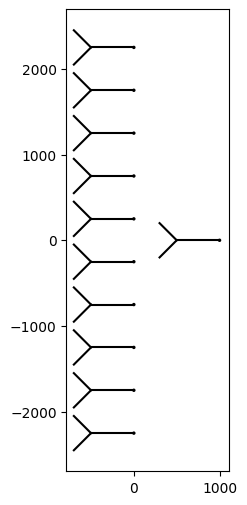

In [87]:
net.rotate(180)
net.arrange_in_layers(layers=[10, 1], within_layer_offset=500, between_layer_offset=1000)

fig, ax = plt.subplots(1, 1, figsize=(3, 6))
_ = net.vis(ax=ax, detail="full")
_ = ax.set_aspect("equal")

As you can see, the neurons are not connected yet. Let's fix this by connecting neurons with synapses. We will build a network consisting of two layers: 10 neurons in the input layer and 1 neuron in the output layer.

For example, we can use `Jaxley`'s `fully_connect` method to connect these layers:

In [88]:
pre = net.cell(range(10))
post = net.cell(10)
fully_connect(pre, post, IonotropicSynapse())

Let's visualize this again:

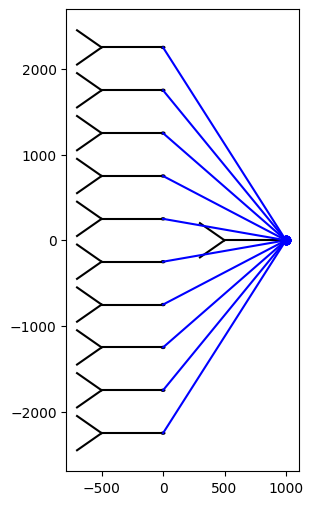

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(3, 6))
_ = net.vis(ax=ax, detail="full")

As you can see, the `fully_connect` method inserted one synapse (in blue) from every neuron in the first layer to the output neuron. The `fully_connect` method builds this synapse from the zero-eth compartment and zero-eth branch of the presynaptic neuron onto the zero-eth compartment and zero-eth branch of the postsynaptic neuron by default. Allowing the post-synaptic compartment to be randomly chosen is also possible by setting `random_post_comp=True` in the `fully_connect` call. If you want more control over the pre- and post-synaptic branches, you can use the `connect` method:

In [90]:
pre = net.cell(0).branch(2).loc(1.0)
post = net.cell(10).branch(1).loc(0.0)
connect(pre, post, IonotropicSynapse())

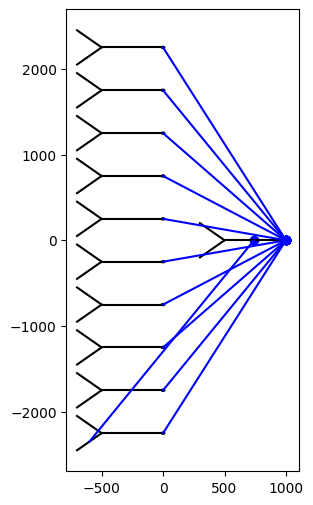

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(3, 6))
_ = net.vis(ax=ax, detail="full")

### Inspecting and changing synaptic parameters

You can inspect synaptic parameters via the `.edges` attribute:

In [92]:
net.edges

,global_edge_index,index_within_type,pre_index,post_index,type,type_ind,pre_locs,post_locs,IonotropicSynapse_gS,IonotropicSynapse_e_syn,IonotropicSynapse_k_minus,IonotropicSynapse_v_th,IonotropicSynapse_delta,IonotropicSynapse_s,controlled_by_param
0,0,0,0,60,IonotropicSynapse,0,0.5,0.5,0.0001,0.0,0.025,-35.0,10.0,0.2,0
1,1,1,6,60,IonotropicSynapse,0,0.5,0.5,0.0001,0.0,0.025,-35.0,10.0,0.2,0
2,2,2,12,60,IonotropicSynapse,0,0.5,0.5,0.0001,0.0,0.025,-35.0,10.0,0.2,0
3,3,3,18,60,IonotropicSynapse,0,0.5,0.5,0.0001,0.0,0.025,-35.0,10.0,0.2,0
4,4,4,24,60,IonotropicSynapse,0,0.5,0.5,0.0001,0.0,0.025,-35.0,10.0,0.2,0
5,5,5,30,60,IonotropicSynapse,0,0.5,0.5,0.0001,0.0,0.025,-35.0,10.0,0.2,0
6,6,6,36,60,IonotropicSynapse,0,0.5,0.5,0.0001,0.0,0.025,-35.0,10.0,0.2,0
7,7,7,42,60,IonotropicSynapse,0,0.5,0.5,0.0001,0.0,0.025,-35.0,10.0,0.2,0
8,8,8,48,60,IonotropicSynapse,0,0.5,0.5,0.0001,0.0,0.025,-35.0,10.0,0.2,0
9,9,9,54,60,IonotropicSynapse,0,0.5,0.5,0.0001,0.0,0.025,-35.0,10.0,0.2,0


To modify a parameter of all synapses you can again use `.set()`:

In [93]:
net.set("IonotropicSynapse_gS", 0.0003)  # nS

To modify individual syanptic parameters, use the `.select()` method. Below, we change the values of the first two synapses:

In [94]:
net.select(edges=[0, 1]).set("IonotropicSynapse_gS", 0.0004)  # nS

For more details on how to flexibly set synaptic parameters (e.g., by cell type, or by pre-synaptic cell index,...), see [this tutorial](https://jaxley.readthedocs.io/en/latest/tutorials/09_advanced_indexing.html).

### Stimulating, recording, and simulating the network

We will now set up a simulation of the network. This works exactly as it does for single neurons:

In [95]:
# Stimulus.
i_delay = 3.0  # ms
i_amp = 1.0  # nA
i_dur = 2.0  # ms

# Duration and step size.
dt = 0.025  # ms
t_max = 50.0  # ms

In [96]:
time_vec = np.arange(0.0, t_max + dt, dt)

As a simple example, we insert sodium, potassium, and leak into every compartment of every cell of the network.

In [97]:
net.insert(Na())
net.insert(K())
net.insert(Leak())

We stimulate every neuron in the input layer and record the voltage from the output neuron:

In [98]:
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
net.delete_stimuli()
for stim_ind in range(10):
    net.cell(stim_ind).branch(0).loc(0.0).stimulate(current)

net.delete_recordings()
net.cell(10).branch(0).loc(0.0).record()

Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.


Finally, we can again run the network simulation and plot the result:

In [99]:
voltages = jx.integrate(net, delta_t=dt)

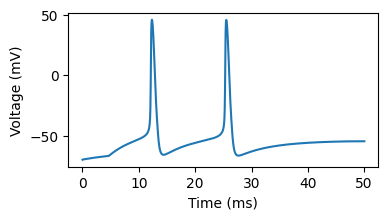

In [102]:
time_vector = np.arange(0, t_max + 2 * dt, dt)

fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = ax.plot(time_vector, voltages.T)
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Voltage (mV)")

That's it! You now know how to simulate networks of morphologically detailed neurons. We recommend that you now have a look at how you can [speed up your simulation](https://jaxley.readthedocs.io/en/latest/tutorials/04_jit_and_vmap.html). To learn more about handling synaptic parameters, we recommend to check out [this tutorial](https://jaxley.readthedocs.io/en/latest/tutorials/09_advanced_indexing.html).

### Coffee break ☕

# Optimizing biophysical models

In this section of the tutorial, you will learn how to train biophysical models in `Jaxley`. This includes the following:

- compute the gradient with respect to parameters  
- use parameter transformations  
- use multi-level checkpointing  
- define optimizers  
- write dataloaders and parallelize across data  

We will use the following functions for this section of the tutorial:

In [229]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad

import jaxley as jx
from jaxley.channels import Leak
from jaxley.synapses import TanhRateSynapse
from jaxley.connect import fully_connect

We will first define a network similar to how we showed previously:

In [230]:
_ = np.random.seed(0)  # For synaptic locations.

cell = jx.read_swc("mini_cell.swc", ncomp=1)
cell.set("axial_resistivity", 100.0)  # ohm cm.
net = jx.Network([cell for _ in range(3)])

pre = net.cell([0, 1])
post = net.cell([2])
fully_connect(pre, post, TanhRateSynapse())

# Change some default values of the tanh synapse.
net.TanhRateSynapse.set("TanhRateSynapse_x_offset", -60.0)
net.TanhRateSynapse.set("TanhRateSynapse_gS", 1e-3)
net.TanhRateSynapse.set("TanhRateSynapse_slope", 0.1)

net.insert(Leak())

This network consists of three neurons arranged in two layers:

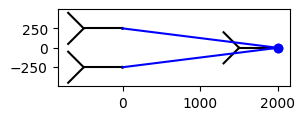

In [231]:
net.rotate(180)
net.arrange_in_layers(layers=[2, 1], within_layer_offset=500, between_layer_offset=2000)
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
_ = net.vis(ax=ax, detail="full")
_ = ax.set_aspect("equal")

We consider the last neuron as the output neuron and record the voltage from there:

In [232]:
net.delete_recordings()
net.cell(0).branch(0).loc(0.0).record()
net.cell(1).branch(0).loc(0.0).record()
net.cell(2).branch(0).loc(0.0).record()

Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


### Defining a dataset

We will train this biophysical network on a classification task. The inputs will be values and the label is binary:

In [233]:
inputs = jnp.asarray(5 * np.random.rand(100, 2))
labels = jnp.asarray((inputs[:, 0] + inputs[:, 1]) > 5.0)

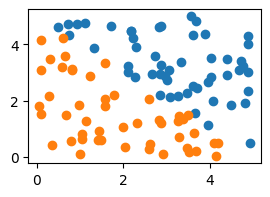

In [234]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
_ = ax.scatter(inputs[labels, 0], inputs[labels, 1])
_ = ax.scatter(inputs[~labels, 0], inputs[~labels, 1])

In [235]:
labels = labels.astype(float)

### Defining trainable parameters

In [236]:
net.delete_trainables()

This follows the same API as `.set()` seen in the previous tutorial. If you want to use a single parameter for every `axial_resistivity` in the entire network, do:

In [237]:
net.make_trainable("axial_resistivity")

Number of newly added trainable parameters: 1. Total number of trainable parameters: 1


We can also define parameters for individual compartments. To do this, use the `"all"` key. The following defines a separate parameter the sodium conductance for every compartment in the entire network:

In [238]:
net.cell("all").branch("all").loc("all").make_trainable("Leak_gLeak")

Number of newly added trainable parameters: 12. Total number of trainable parameters: 13


### Making synaptic parameters trainable

Synaptic parameters can be made trainable in the exact same way. To use a single parameter for all syanptic conductances in the entire network, do
```python
net.TanhRateSynapse.make_trainable("TanhRateSynapse_gS")
```

Here, we use a different syanptic conductance for all syanpses. This can be done as follows:

In [239]:
net.TanhRateSynapse.edge("all").make_trainable("TanhRateSynapse_gS")

Number of newly added trainable parameters: 2. Total number of trainable parameters: 15


### Running the simulation

Once all parameters are defined, you have to use `.get_parameters()` to obtain all trainable parameters. This is also the time to check how many trainable parameters your network has:

In [240]:
params = net.get_parameters()

You can now run the simulation with the trainable parameters by passing them to the `jx.integrate` function.

In [241]:
s = jx.integrate(net, params=params, t_max=10.0)

### Stimulating the network

The network above does not yet get any stimuli. We will use the 2D inputs from the dataset to stimulate the two input neurons. The amplitude of the step current corresponds to the input value. Below is the simulator that defines this:

In [242]:
def simulate(params, inputs):
    currents = jx.datapoint_to_step_currents(i_delay=1.0, i_dur=1.0, i_amp=inputs / 10, delta_t=0.025, t_max=10.0)

    data_stimuli = None
    data_stimuli = net.cell(0).branch(0).loc(1.0).data_stimulate(currents[0], data_stimuli=data_stimuli)
    data_stimuli = net.cell(1).branch(0).loc(1.0).data_stimulate(currents[1], data_stimuli=data_stimuli)

    return jx.integrate(net, params=params, data_stimuli=data_stimuli, delta_t=0.025)

batched_simulate = vmap(simulate, in_axes=(None, 0))

We can also inspect some traces:

In [243]:
traces = batched_simulate(params, inputs[:4])

In [244]:
traces.shape

(4, 3, 402)

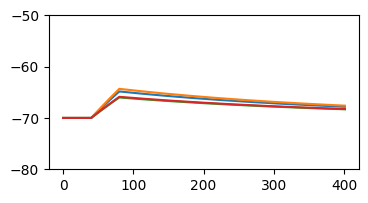

In [245]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = ax.plot(traces[:, 0, :].T)
_ = ax.set_ylim([-80, -50])

### Defining a loss function

Let us define a loss function to be optimized:

In [205]:
def loss(params, inputs, labels):
    traces = batched_simulate(params, inputs)  # Shape `(batchsize, num_recordings, timepoints)`.
    prediction = jnp.mean(traces[:, 2], axis=1)  # Use the average over time of the output neuron (2) as prediction.
    prediction = (prediction + 70.0) / 5  # Such that the prediction is roughly in [0, 1].
    losses = jnp.abs(prediction - labels)  # Mean absolute error loss.
    return jnp.mean(losses)  # Average across the batch.

And we can use `JAX`'s inbuilt functions to take the gradient through the entire ODE:

In [206]:
jitted_grad = jit(value_and_grad(loss, argnums=0))

In [207]:
value, gradient = jitted_grad(params, inputs[:4], labels[:4])

### Defining parameter transformations

Before training, however, we will enforce for all parameters to be within a prespecified range (such that, e.g., conductances can not become negative)

In [208]:
import jaxley.optimize.transforms as jt

In [209]:
# Define a function to create appropriate transforms for each parameter
def create_transform(name):
    if name == "axial_resistivity":
        # Must be positive; apply Softplus and scale to match initialization
        return jt.ChainTransform([jt.SoftplusTransform(0), jt.AffineTransform(5000, 0)])
    elif name == "length":
        # Apply Softplus and affine transform for the 'length' parameter
        return jt.ChainTransform([jt.SoftplusTransform(0), jt.AffineTransform(10, 0)])
    else:
        # Default to a Softplus transform for other parameters
        return jt.SoftplusTransform(0)

# Apply the transforms to the parameters
transforms = [{k: create_transform(k) for k in param} for param in params]
tf = jt.ParamTransform(transforms)


In [210]:
transform = jx.ParamTransform([
    {"axial_resistivity": jt.SigmoidTransform(50.0, 500.0)},
    {"Leak_gLeak":jt.SigmoidTransform(1e-5, 1e-3)},
    {"TanhRateSynapse_gS" : jt.SigmoidTransform(1e-5, 1e-2)}
])

We now modify the loss function to incorporate the parameter transformation into the `loss` function. Below, we summarize the functions we have defined above:

In [220]:
def simulate(params, inputs):
    currents = jx.datapoint_to_step_currents(i_delay=1.0, i_dur=1.0, i_amp=inputs / 10.0, delta_t=dt, t_max=t_max)

    data_stimuli = None
    data_stimuli = net.cell(0).branch(0).loc(1.0).data_stimulate(currents[0], data_stimuli=data_stimuli)
    data_stimuli = net.cell(1).branch(0).loc(1.0).data_stimulate(currents[1], data_stimuli=data_stimuli)

    return jx.integrate(net, params=params, data_stimuli=data_stimuli)

batched_simulate = vmap(simulate, in_axes=(None, 0))


def predict(params, inputs):
    traces = simulate(params, inputs)  # Shape `(batchsize, num_recordings, timepoints)`.
    prediction = jnp.mean(traces[2])  # Use the average over time of the output neuron (2) as prediction.
    return prediction + 70.0  # Such that the prediction is around 0.

batched_predict = vmap(predict, in_axes=(None, 0))


def loss(opt_params, inputs, labels):
    params = transform.forward(opt_params)

    predictions = batched_predict(params, inputs)
    losses = jnp.abs(predictions - labels)  # Mean absolute error loss.
    return jnp.mean(losses)  # Average across the batch.

jitted_grad = jit(value_and_grad(loss, argnums=0))

### Training

We will use the ADAM optimizer from the [optax library](https://optax.readthedocs.io/en/latest/) to optimize the free parameters (you have to install the package with `pip install optax` first):

In [221]:
import optax

In [222]:
opt_params = transform.inverse(params)
optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(opt_params)

### Writing a dataloader

Below, we just write our own (very simple) dataloader. Alternatively, you could use the dataloader from any deep learning library such as pytorch or tensorflow:

In [223]:
class Dataset:
    def __init__(self, inputs: np.ndarray, labels: np.ndarray):
        """Simple Dataloader.
        
        Args:
            inputs: Array of shape (num_samples, num_dim)
            labels: Array of shape (num_samples,)
        """
        assert len(inputs) == len(labels), "Inputs and labels must have same length"
        self.inputs = inputs
        self.labels = labels
        self.num_samples = len(inputs)
        self._rng_state = None
        self.batch_size = 1
    
    def shuffle(self, seed=None):
        """Shuffle the dataset in-place"""
        self._rng_state = np.random.get_state()[1][0] if seed is None else seed
        np.random.seed(self._rng_state)
        indices = np.random.permutation(self.num_samples)
        self.inputs = self.inputs[indices]
        self.labels = self.labels[indices]
        return self
    
    def batch(self, batch_size):
        """Create batches of the data"""
        self.batch_size = batch_size
        return self

    def __iter__(self):
        self.shuffle(seed=self._rng_state)
        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            yield self.inputs[start:end], self.labels[start:end]
        self._rng_state += 1

### Training loop

In [224]:
t_max = 5.0
dt = 0.025

In [225]:
batch_size = 4
dataloader = Dataset(inputs, labels)
dataloader = dataloader.shuffle(seed=0).batch(batch_size)

for epoch in range(10):
    epoch_loss = 0.0
    
    for batch_ind, batch in enumerate(dataloader):
        current_batch, label_batch = batch
        loss_val, gradient = jitted_grad(opt_params, current_batch, label_batch)
        updates, opt_state = optimizer.update(gradient, opt_state)
        opt_params = optax.apply_updates(opt_params, updates)
        epoch_loss += loss_val
    
    print(f"epoch {epoch}, loss {epoch_loss}")
    
final_params = transform.forward(opt_params)

epoch 0, loss 14.154926831713997
epoch 1, loss 13.890769562871833
epoch 2, loss 13.698286410720597
epoch 3, loss 13.558442672153236
epoch 4, loss 13.454427990611467
epoch 5, loss 13.376329657283765
epoch 6, loss 13.31629700953293
epoch 7, loss 13.269531856711438
epoch 8, loss 13.23288677624272
epoch 9, loss 13.203641785587632


In [226]:
ntest = 32
predictions = batched_predict(final_params, inputs[:ntest])

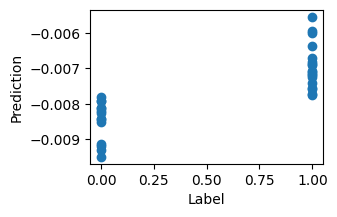

In [227]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
_ = ax.scatter(labels[:ntest], predictions)
_ = ax.set_xlabel("Label")
_ = ax.set_ylabel("Prediction")

Indeed, the loss goes down and the network successfully classifies the patterns.

# Summary

In the first tutorial, we introduced Jaxley and how to build biophysical models. More (and very similar) information can be found in our tutorials online:
- [API basics](https://github.com/jaxleyverse/jaxley/blob/main/docs/tutorials/00_jaxley_api.ipynb)
- [Single-cells with morphology](https://github.com/jaxleyverse/jaxley/blob/main/docs/tutorials/01_morph_neurons.ipynb)
- [Small networks](https://github.com/jaxleyverse/jaxley/blob/main/docs/tutorials/02_small_network.ipynb)
- [Speeding up simulations with jit and vmap](https://github.com/jaxleyverse/jaxley/blob/main/docs/tutorials/04_jit_and_vmap.ipynb)
- [Channel and synapse models](https://github.com/jaxleyverse/jaxley/blob/main/docs/tutorials/05_channel_and_synapse_models.ipynb)
- [Grouping modules](https://github.com/jaxleyverse/jaxley/blob/main/docs/tutorials/06_groups.ipynb)

In the second tutorial, we focused on optimization of biophysical models with Jaxley. This section closely followed our [gradient descent tutorial](https://github.com/jaxleyverse/jaxley/blob/main/docs/tutorials/07_gradient_descent.ipynb) online.
 
If you want to learn more, check out our [Advanced Tutorials](https://jaxley.readthedocs.io/en/latest/advanced_tutorials.html), have a look at our [paper](https://www.biorxiv.org/content/10.1101/2024.08.21.608979v1.abstract), and/or come visit one of our posters at CNS:
- Poster session 1 P065: Jaxley: Differentiable simulation enables large-scale training of detailed biophysical models of neural dynamics
- Poster session 2 P125: Modeling the biophysics of computation in the outer plexiform layer of the mouse retina